In [75]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import time
# NOTE: Importing torch the first time will always take a long time!
print(f"Importing torch ...")
import_torch_start_time = time.time() 
import torch
print(f"Importing torch took {time.time() - import_torch_start_time} seconds")

import importlib # reload custom modules

# Custom modules
import helper
importlib.reload(helper)

from helper import convert
importlib.reload(convert)

from helper import noise
importlib.reload(noise)

from helper.convert import numpy_image_256_to_tensor_with_channel_and_time, tensor_with_channel_and_time_to_numpy_image_256
from helper.noise import add_gaussian_noise
from pdhg.pdhg import pdhg_5D

def reload_modules():
    importlib.reload(helper)
    importlib.reload(convert)
    importlib.reload(noise)
    importlib.reload(add_gaussian_noise)
    importlib.reload(pdhg_5D)
    importlib.reload(tensor_with_channel_and_time_to_numpy_image_256)
    importlib.reload(numpy_image_256_to_tensor_with_channel_and_time)

reload_modules()

Importing torch ...
Importing torch took 2.6464462280273438e-05 seconds
Importing torch in /mnt/c/Users/t/Documents/GIT/DISSERTATION/LearningRegularizationParameterMaps/sidd/helper/convert.py ...
Importing torch took 1.9073486328125e-06 seconds
Importing torch in /mnt/c/Users/t/Documents/GIT/DISSERTATION/LearningRegularizationParameterMaps/sidd/helper/noise.py ...
Importing torch took 1.6689300537109375e-06 seconds
Importing torch in /mnt/c/Users/t/Documents/GIT/DISSERTATION/LearningRegularizationParameterMaps/sidd/helper/convert.py ...
Importing torch took 1.6689300537109375e-06 seconds
Importing torch in /mnt/c/Users/t/Documents/GIT/DISSERTATION/LearningRegularizationParameterMaps/sidd/helper/noise.py ...
Importing torch took 1.430511474609375e-06 seconds


ImportError: module add_gaussian_noise not in sys.modules

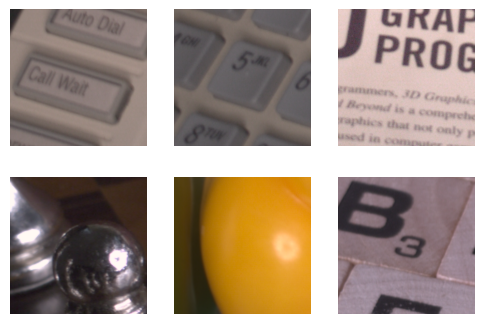

In [5]:
data_path = "data/images/patches"

examples = [
    "0064_GT_SRGB_010_10",
    "0064_GT_SRGB_010_23",
    "0065_GT_SRGB_011_16",
    "0075_GT_SRGB_010_20",
    "0098_GT_SRGB_010_19",
    "0156_GT_SRGB_010_5",
]

example_images = [
    Image.open(f"{data_path}/{ex}.png") for ex in examples
]

def show_examples(examples):
    plt.figure(figsize=(6, 4))
    for i, ex in enumerate(examples):
        example_image = examples[i]
        plt.subplot(2, 3, i+1)
        plt.imshow(example_image, cmap="gray")
        plt.axis("off")
    plt.show();

show_examples(example_images)

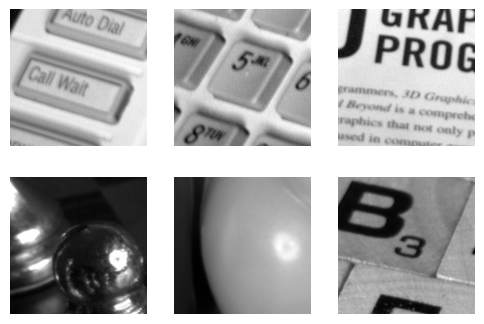

In [15]:
# Test converting to grayscale    
gray_images = [image.convert("L") for image in example_images]
show_examples(gray_images)

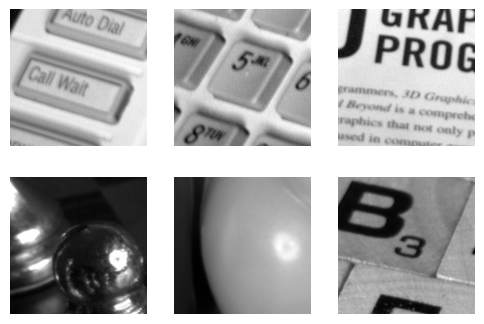

In [16]:
# Test converting to numpy
numpy_images = [np.array(image) for image in gray_images]
for image in numpy_images:
    assert image.shape == (256, 256)
show_examples(numpy_images) # can plot numpy arrays just fine

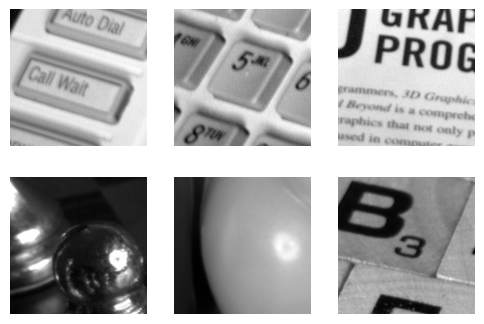

In [43]:
# Test converting to tensor
image_tensors_2D = [torch.tensor(image).float() for image in numpy_images]
for image in image_tensors_2D:
    assert image.shape == (256, 256)
show_examples(image_tensors_2D) # can plot tensors just fine

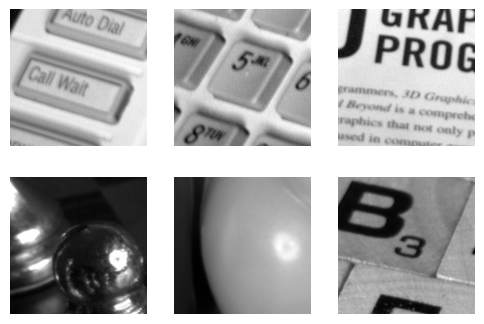

In [44]:
# Test normalising values
max_pixel_value = 255
image_tensors_2D_normalized = [image / max_pixel_value for image in image_tensors_2D]
for image in image_tensors_2D_normalized:
    assert torch.all(image <= 1)
    assert torch.all(image >= 0)
show_examples(image_tensors_2D_normalized)

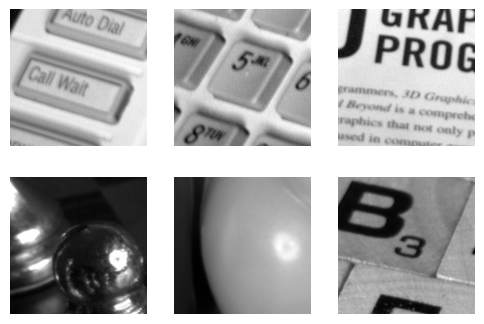

In [50]:
# Test converting to tensor from numpy and back
# Add channel and "time" dimensions: (256, 256) -> (1, 256, 256, 1)
image_tensors = [numpy_image_to_tensor_4D(image) for image in numpy_images]
for image in image_tensors:
    assert image.shape == (1, 256, 256, 1)
min_value = np.inf
max_value = -np.inf
for image in image_tensors:
    assert image.shape == (1, 256, 256, 1)
    min_value = min(min_value, image.min())
    max_value = max(max_value, image.max())
assert min_value >= 0 and max_value <= 1
numpy_images_reconstructed = [tensor_4D_to_numpy_image(image) for image in image_tensors]
for i in range(len(numpy_images)):
    assert np.allclose(numpy_images[i], numpy_images_reconstructed[i])
show_examples(numpy_images_reconstructed)

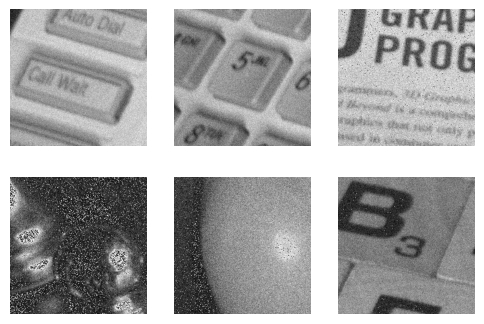

In [29]:
# Test adding noise
noisy_image_tensors = [add_gaussian_noise(image, sigma=0.5) for image in image_tensors]
noisy_image_numpy = [tensor_4D_to_numpy_image(image) for image in noisy_image_tensors]
show_examples(noisy_image_numpy)

PSNR: 28.81, SSIM: 0.52


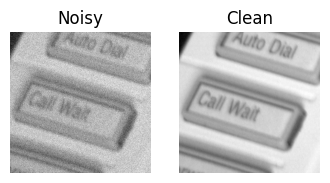

PSNR: 19.68, SSIM: 0.19


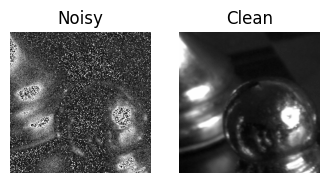

In [47]:
# Test compute PSNR and SSIM
from ignite.metrics import PSNR, SSIM
from ignite.engine import Engine

# create default evaluator for doctests
def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

psnr = PSNR(data_range=1.0)
psnr.attach(default_evaluator, 'psnr')
ssim = SSIM(data_range=1.0)
ssim.attach(default_evaluator, 'ssim')

for i in [0, 3]:
    clean_4D = image_tensors[i]
    noisy_4D = noisy_image_tensors[i]
    # Add batch dimension: (1, 256, 256, 1) -> (1, 1, 256, 256, 1)
    clean_5D_batch = clean_4D.unsqueeze(0)
    noisy_5D_batch = noisy_4D.unsqueeze(0)
    assert clean_5D_batch.shape == noisy_5D_batch.shape == (1, 1, 256, 256, 1)
    # Remove "time" dimension: (1, 1, 256, 256, 1) -> (1, 1, 256, 256)
    clean_4D_batch = clean_5D_batch.squeeze(-1)
    noisy_4D_batch = noisy_5D_batch.squeeze(-1)
    assert clean_4D_batch.shape == noisy_4D_batch.shape == (1, 1, 256, 256)
    state = default_evaluator.run([[clean_4D_batch, noisy_4D_batch]])
    print(f"PSNR: {state.metrics['psnr']:.2f}, SSIM: {state.metrics['ssim']:.2f}")
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(noisy_image_numpy[i], cmap="gray")
    plt.axis("off")
    plt.title("Noisy")
    plt.subplot(1, 2, 2)
    plt.imshow(numpy_images_reconstructed[i], cmap="gray")
    plt.axis("off")
    plt.title("Clean")
    plt.show();


# preds = torch.rand([4, 3, 16, 16])  # NOTE: shape is [batch, channels, height, width]
# target = preds * 0.75
# state = default_evaluator.run([[preds, target]])
# print(state.metrics['psnr'])


In [74]:
reload_modules()

# Test denoising with PDHG
def test_denoise_pdhg(lambda_reg = 0.08, T = 128):
    for i in [0, 3]:
        noisy_image_tensor_4D = noisy_image_tensors[i]

        # Add batch dimension: (1, 256, 256, 1) -> (1, 1, 256, 256, 1)
        noisy_image_tensor_5D_batch = noisy_image_tensor_4D.unsqueeze(0)

        denoised_image_tensor_5D_batch = pdhg_5D(
            noisy_image_tensor_5D_batch, 
            lambda_reg=lambda_reg, 
            T=128
        )
        
        denoised_image_tensor_5D_batch = torch.clamp(denoised_image_tensor_5D_batch, 0, 1) # Clip the values to 0 and 1

        # Remove "time" dimension: (1, 1, 256, 256, 1) -> (1, 1, 256, 256)
        denoised_image_tensor_4D_batch = denoised_image_tensor_5D_batch.squeeze(-1)
        noisy_image_tensor_4D_batch = noisy_image_tensor_5D_batch.squeeze(-1)

        state = default_evaluator.run([[denoised_image_tensor_4D_batch, noisy_image_tensor_4D_batch]])
        print(f"PSNR: {state.metrics['psnr']:.2f}, SSIM: {state.metrics['ssim']:.2f}")

        # Remove the batch dimension: (1, 1, 256, 256, 1) -> (1, 256, 256, 1)
        denoised_image_tensor_4D = denoised_image_tensor_5D_batch.squeeze(0)
        denoised_image_numpy = tensor_4D_to_numpy_image(denoised_image_tensor_4D)
        plt.figure(figsize=(4, 2))
        plt.subplot(1, 2, 1)
        plt.imshow(noisy_image_numpy[i], cmap="gray")
        plt.axis("off")
        plt.title("Noisy")
        plt.subplot(1, 2, 2)
        plt.imshow(denoised_image_numpy, cmap="gray")
        plt.axis("off")
        plt.title("Denoised")
        plt.show();

test_denoise_pdhg(lambda_reg=0.08, T=128)


Importing torch in /mnt/c/Users/t/Documents/GIT/DISSERTATION/LearningRegularizationParameterMaps/sidd/helper/convert.py ...
Importing torch took 1.6689300537109375e-06 seconds


ImportError: module add_gaussian_noise not in sys.modules